# Direct Access to ECCO V4r4 Datasets in the Cloud

imported on: **2023-10-19**

<p>This notebook is from a different repository in NASA's PO.DAAC, ECCO.</p>

> The original source for this document is [https://github.com/podaac/ECCO/blob/main/Data_Access/cloud_direct_access_s3.ipynb](https://github.com/podaac/ECCO/blob/main/Data_Access/cloud_direct_access_s3.ipynb)

# Direct access to ECCO data in S3 (from *us-west-2*)

## Getting Started

In this notebook, we will access monthly sea surface height from ECCO V4r4 ([10.5067/ECG5D-SSH44](https://doi.org/10.5067/ECG5D-SSH44)). The data are provided as a time series of monthly netCDFs on a 0.5-degree latitude/longitude grid. 

We will access the data from inside the AWS cloud (*us-west-2* region, specifically) and load a time series made of multiple netCDF datasets into a single xarray dataset. This approach leverages S3 native protocols for efficient access to the data.

<img src="https://podaac.jpl.nasa.gov/Podaac/thumbnails/ECCO_L4_SSH_05DEG_DAILY_V4R4.jpg" width="50%" />

### Requirements

#### AWS

This notebook should be running in an EC2 instance in AWS region *us-west-2*, as previously mentioned. We recommend using an EC2 with at least 8GB of memory available. 

The notebook was developed and tested using a *t2.large* instance (2 cpus; 8GB memory).

#### Python 3

Most of these imports are from the Python standard library. However, you will need to install these packages into your Python 3 environment if you have not already done so:

* s3fs
* requests
* pandas
* xarray
* matplotlib
* cartopy

In [1]:
import s3fs
import requests
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from json import dumps
from io import StringIO
from os.path import dirname, join
from IPython.display import HTML

plt.rcParams.update({'font.size': 14})

Make a folder to write some outputs, if needed:

In [2]:
!mkdir -p outputs/

### Inputs

Configure one input: the *ShortName* of the desired dataset from ECCO V4r4. In this case it's the following string that unique identifies the collection of monthly, 0.5-degree sea surface height data.

In [3]:
ShortName = "ECCO_L4_SSH_05DEG_MONTHLY_V4R4"

### Earthdata Login

You should have a *.netrc* file set up like:

```
machine urs.earthdata.nasa.gov login <username> password <password>
```

### Direct access from S3

Set up an s3fs session for authneticated access to ECCO netCDF files in s3:

In [4]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

## Datasets

### sea surface height (0.5-degree gridded, monthly)

[ECCO_L4_SSH_05DEG_MONTHLY_V4R4](https://podaac.jpl.nasa.gov/dataset/ECCO_L4_SSH_05DEG_MONTHLY_V4R4)

Get a list of netCDF files located at the S3 path corresponding to the ECCO V4r4 monthly sea surface height dataset on the 0.5-degree latitude/longitude grid.

In [5]:
ssh_Files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, "*2015*.nc"))

len(ssh_Files)

12

Open with the netCDF files using the *s3fs* package, then load them all at once into a concatenated *xarray* dataset.

In [6]:
ssh_Dataset = xr.open_mfdataset(
    paths=[fs.open(f) for f in ssh_Files],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    chunks={'latitude': 60,   # These were chosen arbitrarily. You must specify 
            'longitude': 120, # chunking that is suitable to the data and target
            'time': 100}      # analysis.
)

ssh = ssh_Dataset.SSH

print(ssh)

<xarray.DataArray 'SSH' (time: 12, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(12, 360, 720), dtype=float32, chunksize=(1, 60, 120), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2015-12-16T12:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height anomaly
    standard_name:          sea_surface_height_above_geoid
    units:                  m
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              [-1.88057721]
    valid_max:              [1.42077196]


### Plot the gridded *sea surface height* time series

But only the timesteps beginning in 2015:

In [7]:
ssh_after_201x = ssh[ssh['time.year']>=2015,:,:]

print(ssh_after_201x)

<xarray.DataArray 'SSH' (time: 12, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(12, 360, 720), dtype=float32, chunksize=(1, 60, 120), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2015-12-16T12:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height anomaly
    standard_name:          sea_surface_height_above_geoid
    units:                  m
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              [-1.88057721]
    valid_max:              [1.42077196]


Plot the grid for the first time step using a Robinson projection. Define a helper function for consistency throughout the notebook:

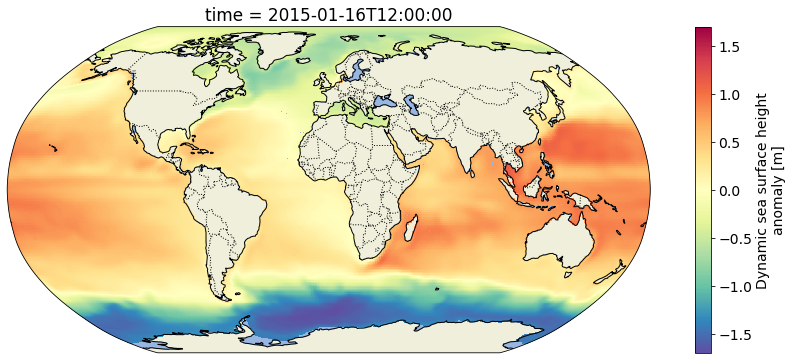

In [8]:
def make_figure(proj):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.add_feature(cfeat.LAND)
    ax.add_feature(cfeat.OCEAN)
    ax.add_feature(cfeat.COASTLINE)
    ax.add_feature(cfeat.BORDERS, linestyle='dotted')
    return fig, ax

fig, ax = make_figure(proj=ccrs.Robinson())

ssh_after_201x.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Spectral_r')

Now plot the whole time series (post-2010) in an animation and write it to an mp4 file called *ecco_monthly_ssh_grid_2015_to_x.mp4*:

In [9]:
def get_animation(var, cmap: str="Spectral_r"):
    """Get time series animation for input xarray dataset"""

    def draw_map(i: int, add_colorbar: bool):
        data = var[i]
        m = data.plot(ax=ax, 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=add_colorbar,
                      vmin=var.valid_min, 
                      vmax=var.valid_max,
                      cmap=cmap)
        plt.title(str(data.time.values)[:7])
        return m

    def init():
        return draw_map(0, add_colorbar=True)
    
    def animate(i):
        return draw_map(i, add_colorbar=False)

    return init, animate

Now make the animation using the function:

In [10]:
fig, ax = make_figure(proj=ccrs.Robinson())

init, animate = get_animation(ssh_after_201x)

ani = animation.FuncAnimation(fig=fig, 
                              func=animate, 
                              frames=ssh_after_201x.time.size, 
                              init_func=init, 
                              interval=0.2, 
                              blit=False, 
                              repeat=False)

# Now save the animation to an MP4 file:
ani.save('outputs/ecco_monthly_ssh_grid_2015_to_x.mp4', writer=animation.FFMpegWriter(fps=8))

plt.close(fig)

Render the animation in the ipynb:

In [11]:
#HTML(ani.to_html5_video())

### tflux (0.5-degree gridded, daily)


Now we will do something similar to access daily, gridded (0.5-degree) ocean and sea-ice surface heat fluxes ([10.5067/ECG5D-HEA44](https://doi.org/10.5067/ECG5D-HEA44)). Read more about the dataset and the rest of the ECCO V4r4 product suite on the [PO.DAAC Web Portal](https://podaac.jpl.nassa.gov). 

Use a "glob" pattern when listing the S3 bucket contents such that only netCDFs from January 2015 are represented in the resulting list of paths.

In [12]:
tflux_Files = fs.glob(join("podaac-ops-cumulus-protected/", "ECCO_L4_HEAT_FLUX_05DEG_DAILY_V4R4", "*2015-01*.nc"))

len(tflux_Files)

31

Now open them all as one xarray dataset just like before. Open and pass the 365 netCDF files to the *xarray.open_mfdataset* constructor so that we can operate on them as a single aggregated dataset.

In [13]:
tflux_Dataset = xr.open_mfdataset(
    paths=[fs.open(f) for f in tflux_Files],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    chunks={'latitude': 60,   # These were chosen arbitrarily. You must specify 
            'longitude': 120, # chunking that is suitable to the data and target
            'time': 100}      # analysis.
)

tflux = tflux_Dataset.TFLUX

print(tflux)

<xarray.DataArray 'TFLUX' (time: 31, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(31, 360, 720), dtype=float32, chunksize=(1, 60, 120), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-01-31T12:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    direction:              >0 increases potential temperature (THETA)
    long_name:              Rate of change of ocean heat content per m2 accou...
    units:                  W m-2
    comment:                The rate of change of ocean heat content due to h...
    valid_min:              [-1713.51220703]
    valid_max:              [870.31304932]


Select a region over the Gulf of Mexico and spatially subset it from the larger dataset by slicing on the *latitude* and *longitude* axes.

In [14]:
tflux_gom = tflux.sel(latitude=slice(15, 40), 
                      longitude=slice(-105, -70))

print(tflux_gom.shape)

(31, 50, 70)


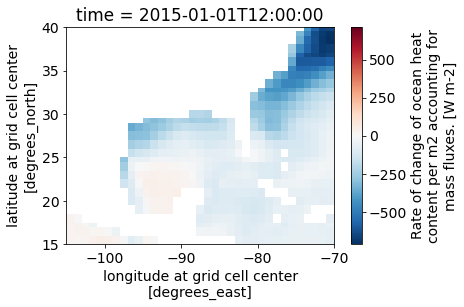

In [15]:
tflux_gom.isel(time=0).plot()

Plot the Jan 2015 surface heat flux as a gridded time series animation over the GOM study region.

In [16]:
fig, ax = make_figure(proj=ccrs.Mercator())

ax.coastlines()
ax.set_extent([tflux_gom.longitude.min(), 
               tflux_gom.longitude.max(), 
               tflux_gom.latitude.min(), 
               tflux_gom.latitude.max()])

init, animate = get_animation(tflux_gom, cmap="RdBu")

# Plot a time series animation write it to an mp4 file:
ani = animation.FuncAnimation(fig=fig, 
                              func=animate, 
                              frames=tflux_gom.time.size, 
                              init_func=init, 
                              interval=0.2, 
                              blit=False, 
                              repeat=False)

ani.save('outputs/ecco_daily_tflux_gom_2015.mp4', writer=animation.FFMpegWriter(fps=8))

plt.close(fig)